In [1]:
sc

In [2]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

import seaborn as sns
sns.set(style="whitegrid")

import fiona
import fiona.crs
import shapely
import rtree

import pandas as pd
import geopandas as gpd


In [3]:
shapefile = 'geo_export_f3f1c046-b582-4f97-980f-48e4f9bcfb7f.shp'
boros = gpd.read_file(shapefile).to_crs(fiona.crs.from_epsg(2263))

In [6]:
def createIndex(shapefile):
    import rtree
    import fiona.crs
    import geopandas as gpd
    zones = gpd.read_file(shapefile).to_crs(fiona.crs.from_epsg(2263))
    index = rtree.Rtree()
    for idx,geometry in enumerate(zones.geometry):
        index.insert(idx, geometry.bounds)
    return (index, zones)

def findZone(p, index, zones):
    match = index.intersection((p.x, p.y, p.x, p.y))
    for idx in match:
        if zones.geometry[idx].contains(p):
            return idx
    return None

def processTrips(pid, records):
    import csv
    import pyproj
    import shapely.geometry as geom
    
    proj = pyproj.Proj(init="epsg:2263", preserve_units=True)    
    index, zones = createIndex('geo_export_f3f1c046-b582-4f97-980f-48e4f9bcfb7f.shp')    
    
    if pid==0:
        records.next()
    reader = csv.reader(records)
    counts = {}
    
    for row in reader:
#         pdt = row[0].split(' ')[1].split(':')[0]
#         if pdt!='10':
#             continue
        p = geom.Point(proj(float(row[7]), float(row[8])))
        zone = findZone(p, index, zones)
        if zone:
            counts[zone] = counts.get(zone, 0) + 1
    return counts.items()
            
rdd = sc.textFile('1klines.csv')
counts = rdd.mapPartitionsWithIndex(processTrips)
counts = counts.reduceByKey(lambda x,y: x+y)
# counts.collect()
counts = counts.collect()
len(counts)


4

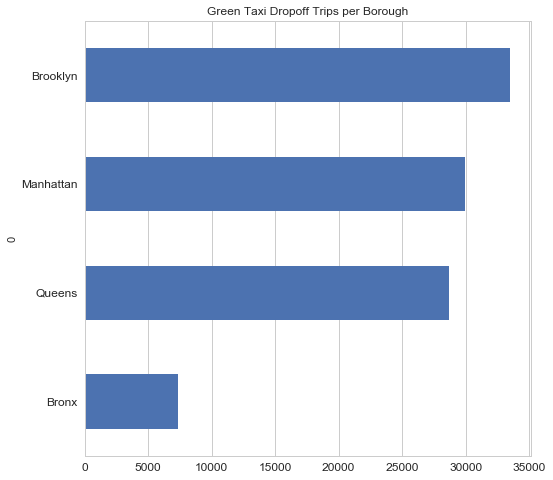

In [7]:
countsPerBoro = map(lambda x: (boros['boro_name'][x[0]], x[1]), counts)
df = pd.DataFrame(countsPerBoro).sort_values(1).set_index(0)
df.plot(kind='barh', title='Green Taxi Dropoff Trips per Borough', figsize=(8,8), fontsize=12, legend=False)
plt.axes().yaxis.grid(False)